In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# create a class LMC with single input and single output
class LMCneuron:
    def __init__(self, inputs, vL, g):
        self.s = inputs
        self.vL = vL # resting potential
        self.g = g # conductance
        self.v = None # outputs
        self.alpha = 0.1 # scaling factor for calcium response


    def neuron_out(self):
        self.v = np.zeros_like(self.s) # outputs
        self.v[0] = self.vL
        for t in range(1, len(self.s)):
            dv_dt = -(self.v[t-1] - self.vL) + (1 / self.g) * self.s[t-1]
            self.v[t] = self.v[t-1] + dv_dt

            # Calcium response
            x = self.v[t] #+ (1 / self.g)*self.s[t-1]  # Input to rectifier
            self.v[t] = self.alpha * np.maximum(self.vL, x)
        return self.v

In [14]:
## preparing stimulus
dt = 0.1  # Time step (ms)
# Stimulus: s(t) (e.g., sinusoidal stimulus for moving gratings)
frequency = 10  # Frequency of the stimulus (Hz)
T = 50  # Total time (ms)
time = np.arange(0, T, dt)  # Time array
blank = -4*np.ones((200))
s0 = 0.5*np.sin(2 * np.pi * frequency * time / 100)  # Scale appropriately
s1 = np.sin(2 * np.pi * frequency * time / 100)  # Scale appropriately
s2 = 2*np.sin(2 * np.pi * frequency * time / 100)  # Scale appropriately
s3 = 3*np.sin(2 * np.pi * frequency * time / 100)  # Scale appropriately
s4 = 4*np.sin(2 * np.pi * frequency * time / 100)  # Scale appropriately
s = np.concatenate((s0,blank,s1,blank,s2,blank,s3,blank,s4,blank), axis = 0)
print(s.shape)

(3500,)


In [15]:
s = s-np.min(s)
s = s/np.max(s) ## restrict range from 0 to 1

print(np.min(s), np.max(s), np.mean(s))

0.0 1.0 0.35714285714285715


In [16]:
neuron = LMCneuron(s, -0.03, 0.5)
v = neuron.neuron_out()

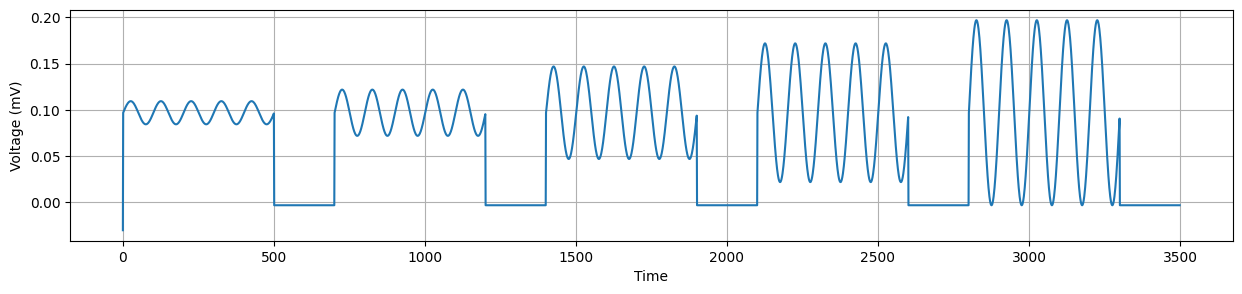

In [17]:
plt.figure(figsize = (15,3))
plt.plot(v, label='Membrane Potential (v)')
plt.ylabel('Voltage (mV)')
plt.xlabel('Time')
plt.grid()
plt.savefig("sine_nonpool.png", dpi=300, bbox_inches="tight")

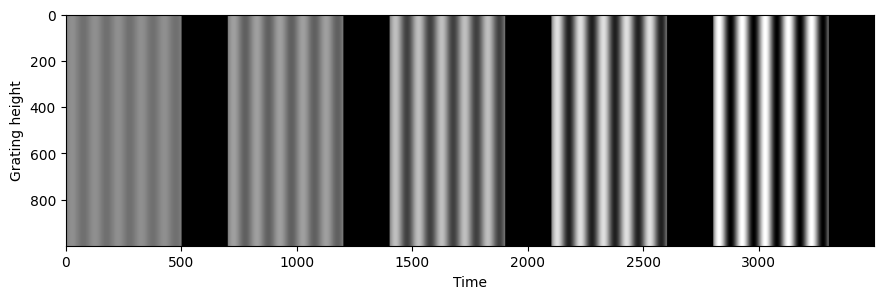

In [18]:
s = s/np.max(s)
st = np.expand_dims(s, axis = 1)
st = np.repeat(st,repeats = 1000, axis = 1).T
plt.figure(figsize = (15,3))
plt.imshow(st, cmap = 'gray')
plt.ylabel('Grating height')
plt.xlabel('Time')
plt.savefig("sine.png", dpi=300, bbox_inches="tight")

In [19]:
np.max(s)

1.0

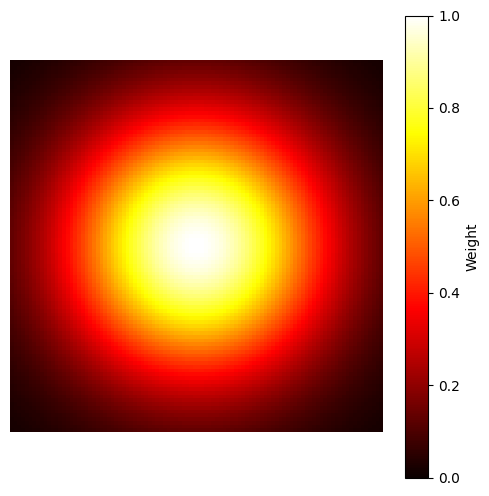

In [35]:
from matplotlib.colors import Normalize

# Generate Gaussian mask
def generate_gaussian_mask(size, sigma):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    x, y = np.meshgrid(x, y)
    gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return gaussian

# Parameters for the Gaussian mask
size = 100  # Size of the mask (100x100)
sigma = 0.5  # Standard deviation

# Generate the mask
gaussian_mask = generate_gaussian_mask(size, sigma)

# Plot and save with "hot" colormap
plt.figure(figsize=(6, 6))
plt.imshow(gaussian_mask, cmap="hot", norm=Normalize(vmin=0, vmax=1))
plt.colorbar(label='Weight')
plt.axis("off")  # Remove axes for a clean image
#plt.title("Gaussian Mask (Hot Colormap)")
plt.savefig("gaussian_mask_hot.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

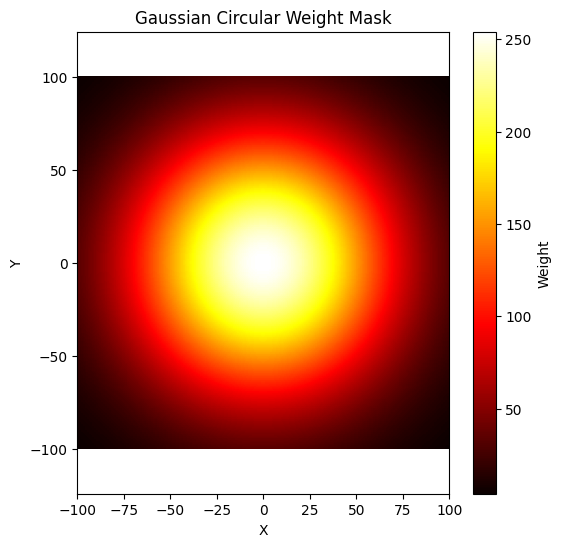

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_circular_weight_mask(size, sigma):
    # Create a grid of x, y coordinates
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    xv, yv = np.meshgrid(x, y)

    # Compute the distance from the center for each grid point
    distance_squared = xv**2 + yv**2

    # Apply the Gaussian function
    mask = np.exp(-distance_squared / (2 * sigma**2))

    # Normalize the weights to ensure the sum of the mask is 1
    mask /= np.sum(mask)

    return mask

# Parameters
size = 200  # Size of the square array
sigma = 50  # Standard deviation of the Gaussian distribution

# Generate the mask
gaussian_mask = gaussian_circular_weight_mask(size, sigma)

gaussian_mask = np.array((gaussian_mask)*255/np.max(gaussian_mask), dtype = 'uint8')
# Plot the mask
plt.figure(figsize=(6, 6))
plt.imshow(gaussian_mask, cmap='hot', extent=[-size // 2, size // 2, -size // 2, size // 2])
plt.colorbar(label='Weight')
plt.title('Gaussian Circular Weight Mask')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()
#plt.savefig("gaussian_mask.png", dpi=300, bbox_inches="tight")

In [38]:
np.max(gaussian_mask), np.mean(gaussian_mask), np.min(gaussian_mask)

(254, 90.0398, 4)

In [39]:
## weighted stimulus
a = st.shape[1]
b = gaussian_mask.shape[0]
stimuli = []
for i in range(0, a-b):
    mask = st[0:b, i:b+i]*gaussian_mask
    stimuli.append(np.max(mask))
stimuli = np.array(stimuli)

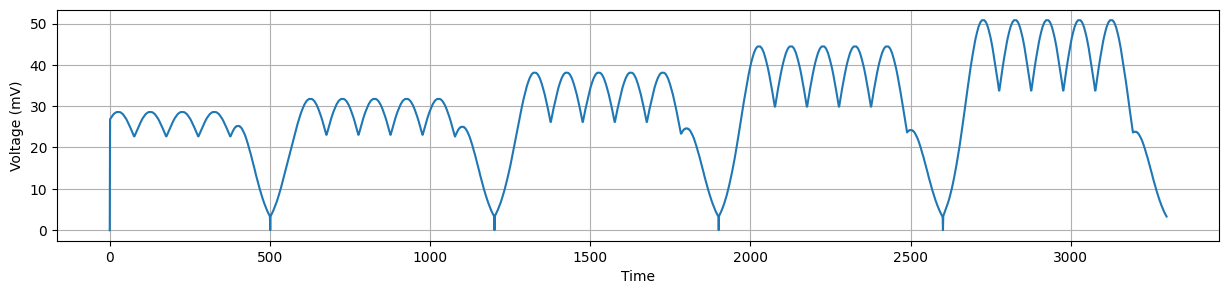

In [40]:
neuron_pooled = LMCneuron(stimuli, -0.03, 0.5)
v = neuron_pooled.neuron_out()

plt.figure(figsize = (15,3))
plt.plot(v, label='Membrane Potential (v)')
plt.ylabel('Voltage (mV)')
plt.xlabel('Time')
plt.grid()
plt.savefig("sine_pool.png", dpi=300, bbox_inches="tight")

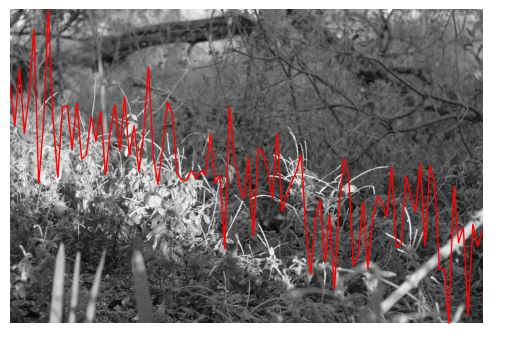

In [71]:
# Parameters
omega = 0.01  # Frequency factor for the sine component
gamma = 2.5  # Slope for the linear component
z_values = np.linspace(0, 10, 100)  # Z-axis values (adjust range as needed)

# Random trajectory equation
def trajectory(z, omega, gamma):
    noise = np.random.normal(0, 0.1, len(z))  # Gaussian noise
    return 30 * np.sin(2 * np.pi * 3 * omega * z/1000) + gamma * z + 60 * noise

# Generate trajectory
T_values = trajectory(z_values, omega, gamma)

# Load and display the image
image_path = "DSC_1751.jpg"  # Replace with your image path
image = cv2.imread(image_path, 0)
image = image/255
plt.imshow(image, cmap = 'gray')
plt.axis("off")

# Normalize trajectory to fit within the image dimensions
image_width, image_height = image.shape[1], image.shape[0]
z_scaled = np.interp(z_values, (z_values.min(), z_values.max()), (0, image_width))
T_scaled = np.interp(T_values, (T_values.min(), T_values.max()), (0, image_height))

# Overlay trajectory on the image
plt.plot(z_scaled, T_scaled, color="red", linewidth=1)

# Show the result
plt.show()

In [72]:
### stimuli input from image
input = []
for i in range(len(z_scaled)):
    x = int(z_scaled[i])-1
    y = int(T_scaled[i])-1
    input.append(image[y,x])

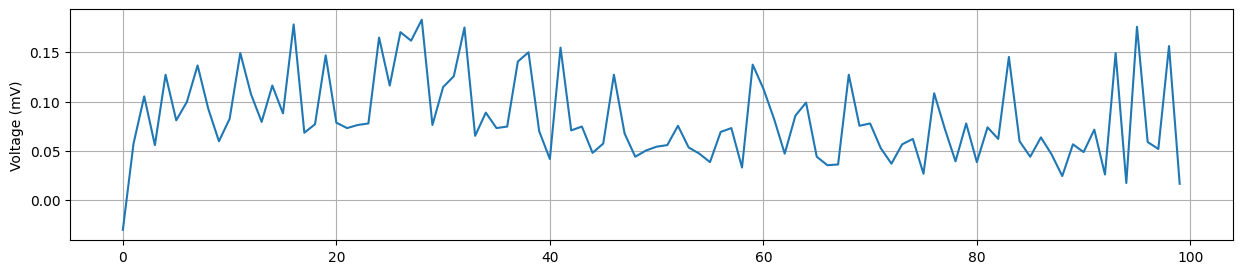

In [73]:
neuron = LMCneuron(input, -0.03, 0.5)
out = neuron.neuron_out()

plt.figure(figsize = (15,3))
plt.plot(out, label='Membrane Potential (v)')
plt.ylabel('Voltage (mV)')
plt.grid()

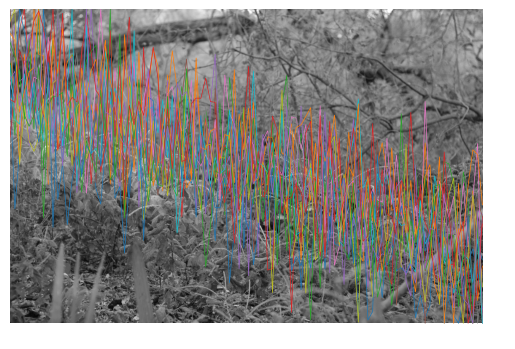

<Figure size 640x480 with 0 Axes>

In [43]:
# Parameters
omega = 0.01  # Frequency factor for the sine component
gamma = 2.5  # Slope for the linear component
z_values = np.linspace(0, 10, 100)  # Z-axis values (adjust range as needed)
num_trajectories = 15  # Number of trajectories to plot

# Random trajectory equation
def trajectory(z, omega, gamma):
    noise = np.random.normal(0, 0.1, len(z))  # Gaussian noise
    return 30 * np.sin(2 * np.pi * 3 * omega * z / 1000) + gamma * z + 60 * noise

# Load and display the image
image_path = "DSC_1803.jpg"  # Replace with your image path
image = cv2.imread(image_path, 0)  # Normalize image intensity
plt.imshow(image, cmap='gray')
plt.axis("off")

image = image/255
# image dimensions
image_width, image_height = image.shape[1], image.shape[0]

trajectories_output = []
# Plot multiple trajectories
for _ in range(num_trajectories):
    # Generate trajectory
    T_values = trajectory(z_values, omega, gamma)

    # Normalize trajectory to fit within the image dimensions
    z_scaled = np.interp(z_values, (z_values.min(), z_values.max()), (0, image_width))
    T_scaled = np.interp(T_values, (T_values.min(), T_values.max()), (0, image_height))

    # Overlay trajectory on the image
    plt.plot(z_scaled, T_scaled, linewidth=0.5)

    ### stimuli input from image
    input = []
    for i in range(len(z_scaled)):
        x = int(z_scaled[i])-1
        y = int(T_scaled[i])-1
        input.append(image[y,x])

    neuron = LMCneuron(input, -0.03, 0.5)
    out = neuron.neuron_out()
    trajectories_output.append(out)

# Show the result
plt.show()
to_dark = np.array(trajectories_output)
plt.savefig("dark_traj.png", dpi=300, bbox_inches="tight")

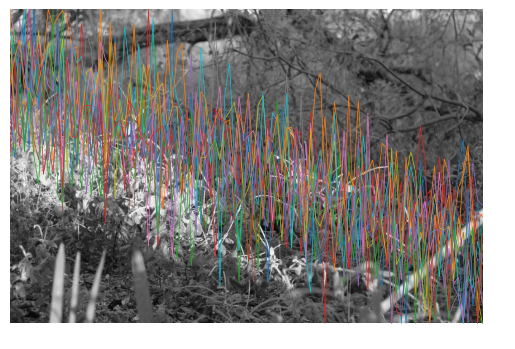

In [45]:
# Parameters
omega = 0.01  # Frequency factor for the sine component
gamma = 2.5  # Slope for the linear component
z_values = np.linspace(0, 10, 100)  # Z-axis values (adjust range as needed)
num_trajectories = 15  # Number of trajectories to plot

# Random trajectory equation
def trajectory(z, omega, gamma):
    noise = np.random.normal(0, 0.1, len(z))  # Gaussian noise
    return 30 * np.sin(2 * np.pi * 3 * omega * z / 1000) + gamma * z + 60 * noise

# Load and display the image
image_path = "DSC_1751.jpg"  # Replace with your image path
image = cv2.imread(image_path, 0) / 255  # Normalize image intensity
plt.imshow(image, cmap='gray')
plt.axis("off")

# image dimensions
image_width, image_height = image.shape[1], image.shape[0]

trajectories_output = []
# Plot multiple trajectories
for _ in range(num_trajectories):
    # Generate trajectory
    T_values = trajectory(z_values, omega, gamma)

    # Normalize trajectory to fit within the image dimensions
    z_scaled = np.interp(z_values, (z_values.min(), z_values.max()), (0, image_width))
    T_scaled = np.interp(T_values, (T_values.min(), T_values.max()), (0, image_height))

    # Overlay trajectory on the image
    plt.plot(z_scaled, T_scaled, linewidth=0.5)

    ### stimuli input from image
    input = []
    for i in range(len(z_scaled)):
        x = int(z_scaled[i])-1
        y = int(T_scaled[i])-1
        input.append(image[y,x])

    neuron = LMCneuron(input, -0.03, 0.5)
    out = neuron.neuron_out()
    trajectories_output.append(out)

# Show the result
plt.show()
to = np.array(trajectories_output)

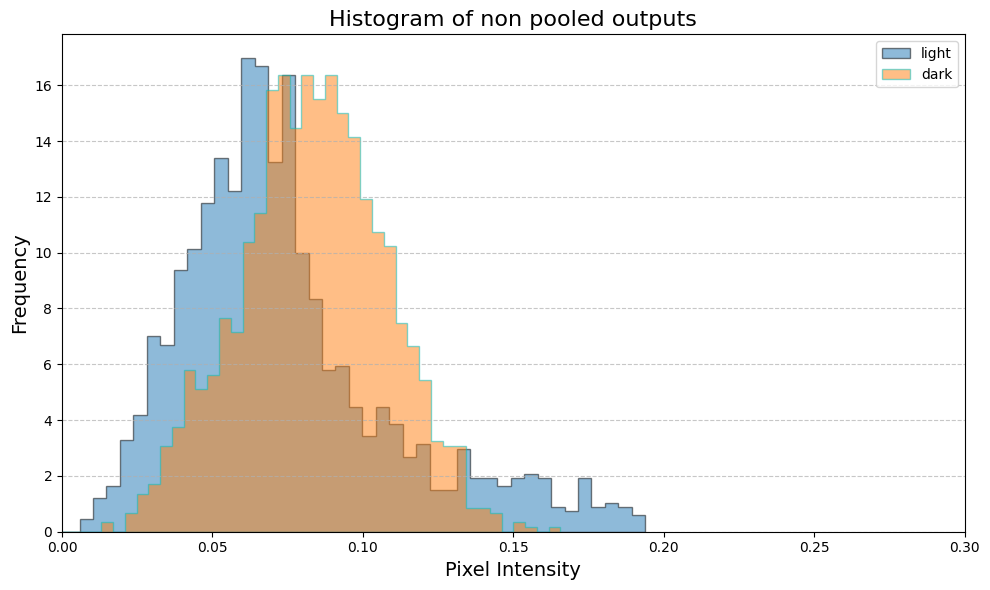

In [46]:
data_flat_to = to.flatten()
data_flat_to_dark = to_dark.flatten()


# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_flat_to, density=True, histtype='stepfilled', alpha=0.5, bins=50, ec="k", lw=1, label = 'light')
plt.hist(data_flat_to_dark, density=True, histtype='stepfilled', alpha=0.5, bins=50, ec="c", lw=1, label = 'dark')

# Add labels and title
plt.title("Histogram of non pooled outputs", fontsize=16)
plt.xlabel("Pixel Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim(0, 0.3)
plt.legend()
# Grid and aesthetics
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("histogram_npool.png", dpi=300, bbox_inches="tight")

In [ ]:
## pooled inputs